In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    LabelEncoder, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression


# 📑 Project Summary (EDA → Prep → Baseline Model)

## 1) Data & Objective
- **Dataset:** 50k transactions with `User_Name, Age, Country, Product_Category, Purchase_Amount, Payment_Method, Transaction_Date`
- **Target (y):** `Product_Category`
- **Features (X):** `Age, Purchase_Amount, Year, Month, Day` + one-hots for `Country` and `Payment_Method`

## 2) EDA Highlights
- Classes are **balanced** (~6.2k each).
- Correlations with `Product_Category_Label` are **weak** → linear model (LogReg) performs near chance (~0.125).
- Seasonal/monthly patterns exist; moderate spread in age/amount.

## 3) Data Preparation
- Parse date → create `Year/Month/Day`
- One-hot encode `Country`, `Payment_Method`
- Label-encode target `Product_Category` → `Product_Category_Label`

## 4) Baseline Model: Multinomial Logistic Regression
> Due to weak linear signal, accuracy was close to random guessing across 8 classes.

## 5) Correlation Heatmap
- Shows weak correlation between features and target.

## 6) Next Steps
- **Feature Engineering:** age/amount bins, `DayOfWeek/IsWeekend/Quarter`, interactions like `Country × Payment_Method`, `AgeGroup × Payment_Method`.
- **Non-linear Models:** `RandomForest`, `XGBoost/LightGBM` (often stronger for tabular data).
- **Evaluation:** macro/weighted F1, confusion matrix, and **Top-k accuracy** for recommender-style use.

---

<div dir="rtl" align="right">

# 📑 خلاصهٔ پروژهٔ پیش‌بینی دستهٔ محصول (EDA → Prep → Baseline Model)

## ۱) داده و هدف
- **دیتاست:** 50,000 تراکنش با ستون‌ها: `User_Name, Age, Country, Product_Category, Purchase_Amount, Payment_Method, Transaction_Date`
- **هدف (y):** پیش‌بینی `Product_Category`
- **ویژگی‌ها (X):** `Age, Purchase_Amount, Year, Month, Day` + وان‌هات‌های `Country` و `Payment_Method`

## ۲) EDA (نکات کلیدی)
- کلاس‌ها تقریباً **متعادل** هستند (هرکدام ≈ ۶.۲k).
- همبستگی‌ها با `Product_Category_Label` خیلی **کم** است → مدل خطی (لاجستیک) عملکرد ضعیف داشت (~0.125).
- روندهای سال/ماه قابل مشاهده؛ توزیع سن و مبلغ پراکندگی متوسط دارد.

## ۳) آماده‌سازی داده
- تبدیل تاریخ به `datetime` و استخراج `Year/Month/Day`
- وان‌هات برای `Country` و `Payment_Method`
- تبدیل برچسب هدف به عدد: `Product_Category_Label`

## ۴) مدل پایه (Logistic Regression چندکلاسه)
> به‌خاطر همبستگی کم و مرزهای غیرخطی، دقت نزدیک شانسی بود.

## ۵) Heatmap همبستگی (برای دید کلی)
- نشون داد که فیچرها با هدف همبستگی قوی ندارن.

## ۶) مسیر پیشنهادی بهبود
- **Feature Engineering:**  
  - بازه‌های سنی (Age bins)، بازه‌های مبلغ (Low/Medium/High)، `DayOfWeek/IsWeekend/Quarter`  
  - تعامل‌ها (Interactions): `Country × Payment_Method`، `AgeGroup × Payment_Method`
- **مدل‌های غیرخطی:** `RandomForest`, `XGBoost/LightGBM` (برای دادهٔ جدولی معمولاً بهترند)
- **ارزیابی تکمیلی:** `macro/weighted F1`، ماتریس اغتشاش، و **Top-k accuracy** برای سناریوی توصیه‌گر

</div>


In [10]:
df = pd.read_csv(r"C:\Users\User\Desktop\ML folders\E-Commerce Transactions Dataset\ecommerce_transactions.csv")
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction_ID    50000 non-null  int64  
 1   User_Name         50000 non-null  object 
 2   Age               50000 non-null  int64  
 3   Country           50000 non-null  object 
 4   Product_Category  50000 non-null  object 
 5   Purchase_Amount   50000 non-null  float64
 6   Payment_Method    50000 non-null  object 
 7   Transaction_Date  50000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.1+ MB
None
       Transaction_ID           Age  Purchase_Amount
count    50000.000000  50000.000000     50000.000000
mean     25000.500000     43.968680       503.159793
std      14433.901067     15.260578       286.563558
min          1.000000     18.000000         5.040000
25%      12500.750000     31.000000       255.450000
50%      25000.500000     44.000000  

# 📊 Data Overview

## Dataset Info
- Records: **50,000**
- Columns: **8**
- Data Types:
  - `Transaction_ID`: Numeric (int64) → unique transaction ID
  - `User_Name`: Text (object) → user’s name
  - `Age`: Numeric (int64) → user’s age
  - `Country`: Text (object) → user’s country
  - `Product_Category`: Text (object) → purchased product category
  - `Purchase_Amount`: Numeric (float64) → purchase amount
  - `Payment_Method`: Text (object) → payment method (Credit Card, PayPal, etc.)
  - `Transaction_Date`: Text (object) → transaction date (needs conversion to datetime)

---

## Descriptive Statistics
### Transaction_ID
- Range: 1 → 50,000  
- Unique IDs, only serve as transaction identifiers.

### Age
- Range: **18 → 70**
- Mean ≈ 44  
- Median = 44  
- Most users are in the **31–57** age group (IQR).

### Purchase_Amount
- Range: **5.04 → 999.98**
- Mean ≈ 503  
- Median = 503 (distribution nearly symmetric)  
- Quartiles:  
  - Q1 = 255.45  
  - Q3 = 751.16  
  → Most purchases fall between 250 and 750.

---

## Key Notes
- Dataset is **complete** (no null values).  
- Text columns (`Country`, `Product_Category`, `Payment_Method`, `Transaction_Date`) require preprocessing:  
  - Convert `Transaction_Date` → datetime  
  - Encode categorical columns (One-Hot / Label Encoding)  
- `Transaction_ID` is just an identifier and should not be used for modeling.

---

<div dir="rtl" align="right">

# 📊 مرور داده‌ها

## اطلاعات دیتاست
- تعداد رکوردها: **۵۰,۰۰۰**
- تعداد ستون‌ها: **۸**
- نوع داده‌ها:
  - `Transaction_ID`: عددی (int64) → شناسهٔ یکتای تراکنش
  - `User_Name`: متنی (object) → نام کاربر
  - `Age`: عددی (int64) → سن کاربر
  - `Country`: متنی (object) → کشور کاربر
  - `Product_Category`: متنی (object) → دستهٔ محصول خریداری‌شده
  - `Purchase_Amount`: عددی (float64) → مبلغ خرید
  - `Payment_Method`: متنی (object) → روش پرداخت (کارت، پی‌پال و …)
  - `Transaction_Date`: متنی (object) → تاریخ تراکنش (باید به datetime تبدیل شود)

---

## آمار توصیفی
### Transaction_ID
- بازه: 1 → 50,000  
- یکتا هستند و فقط به عنوان شناسه استفاده م


In [11]:
### tabdil data be halat time
df["Transaction_Date"] = pd.to_datetime(df["Transaction_Date"])
### joda kardane rooz mah sal besoorate sotoon sotoon
df["Year"] = df["Transaction_Date"].dt.year
df["Month"] = df["Transaction_Date"].dt.month
df["Day"] = df["Transaction_Date"].dt.day
### joda sazi rooz /mah /sal
### hazfe sotoon Transaction_Date
df.drop("Transaction_Date", axis=1, inplace=True)
df.drop("Transaction_ID",axis =1, inplace = True)
df.drop("User_Name",axis =1 ,inplace = True)

# ⏳ Data Cleaning & Date Processing

## Steps Performed
1. **Converted Transaction_Date → datetime**
   - Extracted components into new columns: `Year`, `Month`, `Day`.

2. **Dropped unnecessary columns**
   - `Transaction_Date` → replaced by `Year/Month/Day`.
   - `Transaction_ID` → only an identifier, no predictive value.
   - `User_Name` → textual name, not useful for analysis/modeling.

---

## Final Columns in Dataset
- `Age`  
- `Country`  
- `Product_Category`  
- `Purchase_Amount`  
- `Payment_Method`  
- `Year`  
- `Month`  
- `Day`  

---

<div dir="rtl" align="right">

# ⏳ پاک‌سازی داده و پردازش تاریخ

## مراحل انجام‌شده
1. **تبدیل ستون Transaction_Date به datetime**
   - جداسازی تاریخ به سه ستون جدید: `Year`, `Month`, `Day`.

2. **حذف ستون‌های غیرضروری**
   - `Transaction_Date` → چون به سال/ماه/روز تبدیل شد.  
   - `Transaction_ID` → فقط شناسهٔ تراکنش بود، کاربرد تحلیلی ندارد.  
   - `User_Name` → نام کاربر است و برای مدل‌سازی مفید نیست.  

---

## ستون‌های نهایی دیتاست
- `Age`  
- `Country`  
- `Product_Category`  
- `Purchase_Amount`  
- `Payment_Method`  
- `Year`  
- `Month`  
- `Day`  

</div>


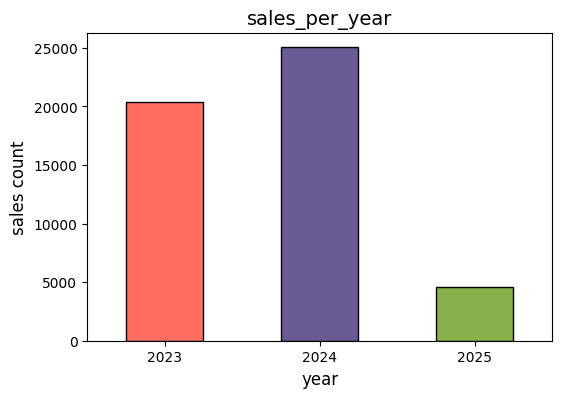

Year
2023    20416
2024    25039
2025     4545
Name: count, dtype: int64


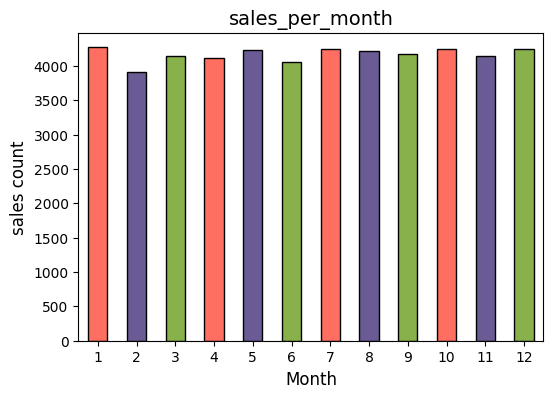

Month
1     4271
2     3918
3     4139
4     4116
5     4234
6     4052
7     4246
8     4213
9     4169
10    4247
11    4149
12    4246
Name: count, dtype: int64


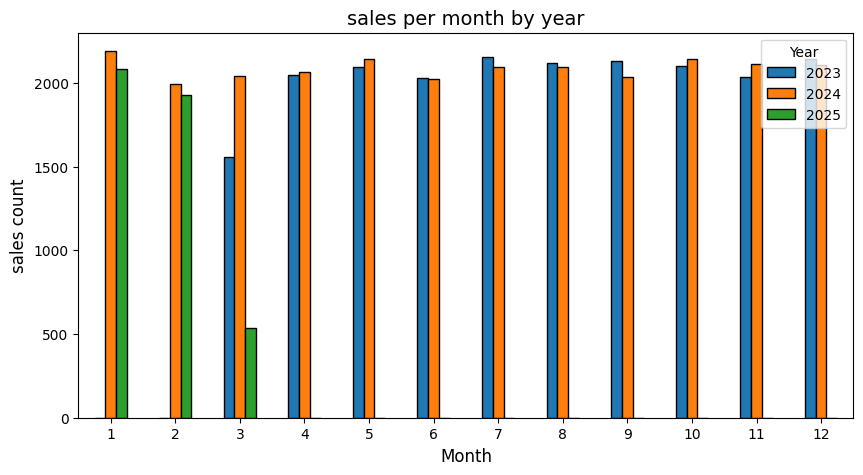

Month    1     2     3     4     5     6     7     8     9     10    11    12
Year                                                                         
2023      0     0  1560  2049  2092  2029  2154  2120  2132  2103  2036  2141
2024   2190  1992  2041  2067  2142  2023  2092  2093  2037  2144  2113  2105
2025   2081  1926   538     0     0     0     0     0     0     0     0     0


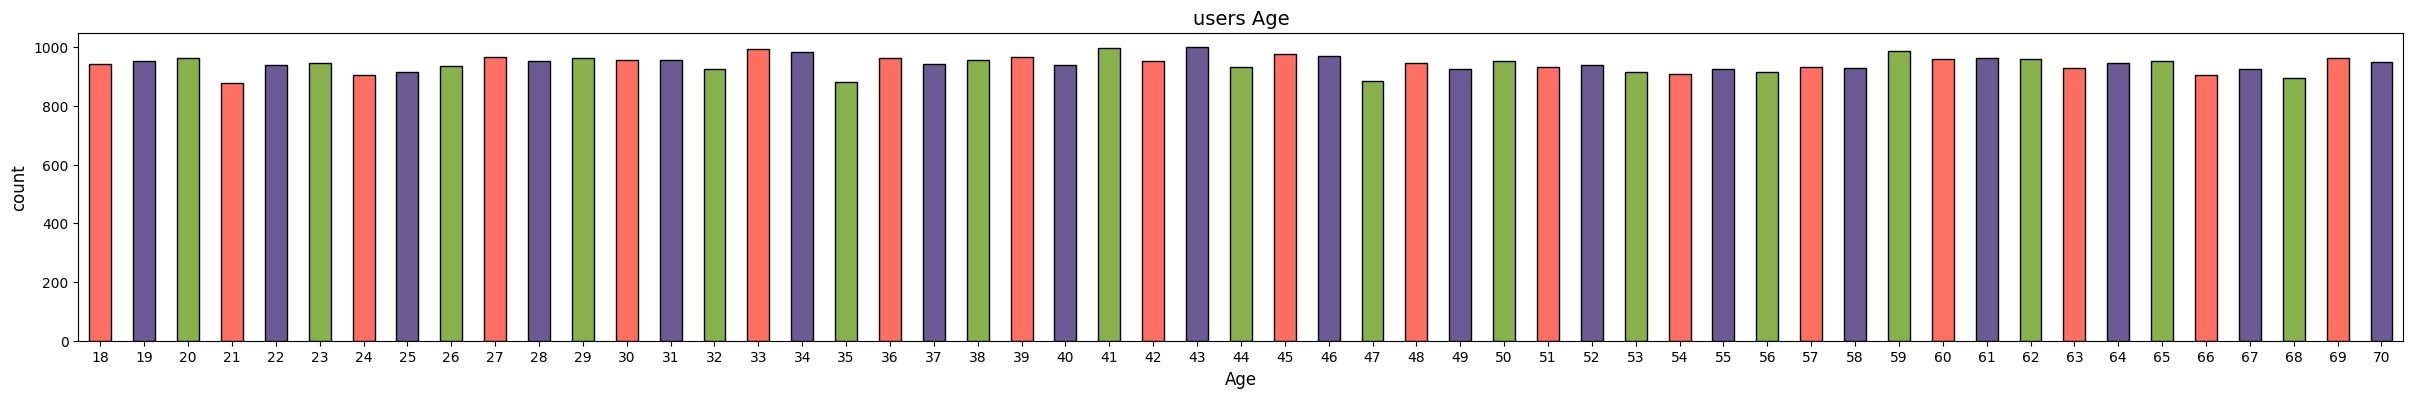

Age
18    942
19    953
20    964
21    877
22    940
23    947
24    906
25    914
26    935
27    966
28    951
29    963
30    957
31    956
32    927
33    994
34    982
35    882
36    963
37    943
38    956
39    967
40    940
41    997
42    953
43    999
44    933
45    977
46    971
47    886
48    947
49    927
50    952
51    932
52    940
53    914
54    907
55    927
56    914
57    932
58    930
59    988
60    959
61    964
62    961
63    929
64    946
65    952
66    906
67    926
68    896
69    962
70    948
Name: count, dtype: int64


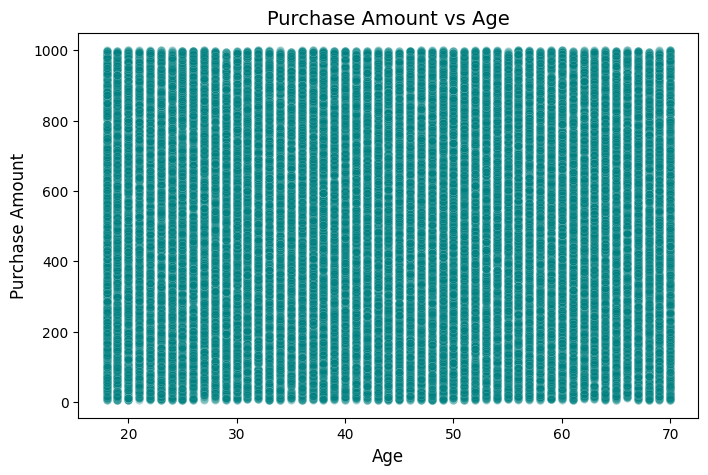

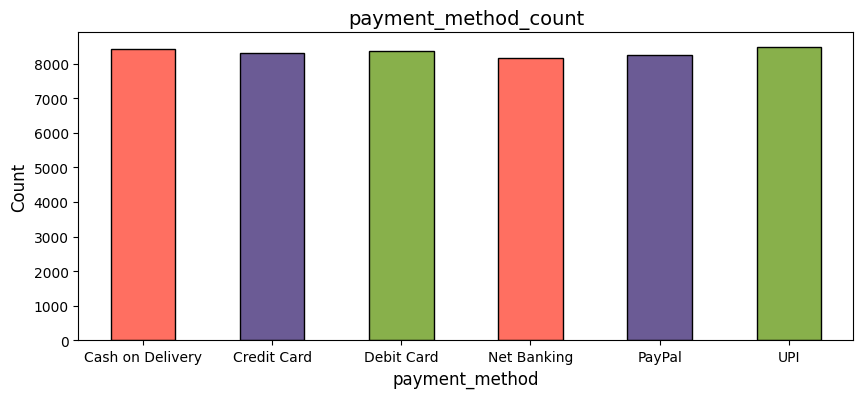

Payment_Method
Cash on Delivery    8434
Credit Card         8310
Debit Card          8355
Net Banking         8174
PayPal              8250
UPI                 8477
Name: count, dtype: int64
Payment_Method  Cash on Delivery  Credit Card  Debit Card  Net Banking  \
Age_Group                                                                
18-37                       3048         2967        3080         2885   
38-57                       3131         3121        3083         3099   
58-77                       2087         2063        2030         2041   

Payment_Method  PayPal   UPI  
Age_Group                     
18-37             2918  3022  
38-57             3217  3220  
58-77             1966  2080  


C:\Users\User\AppData\Local\Temp\ipykernel_11404\3264426025.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  payment_age = df.groupby(["Age_Group", "Payment_Method"]).size().unstack(fill_value=0)


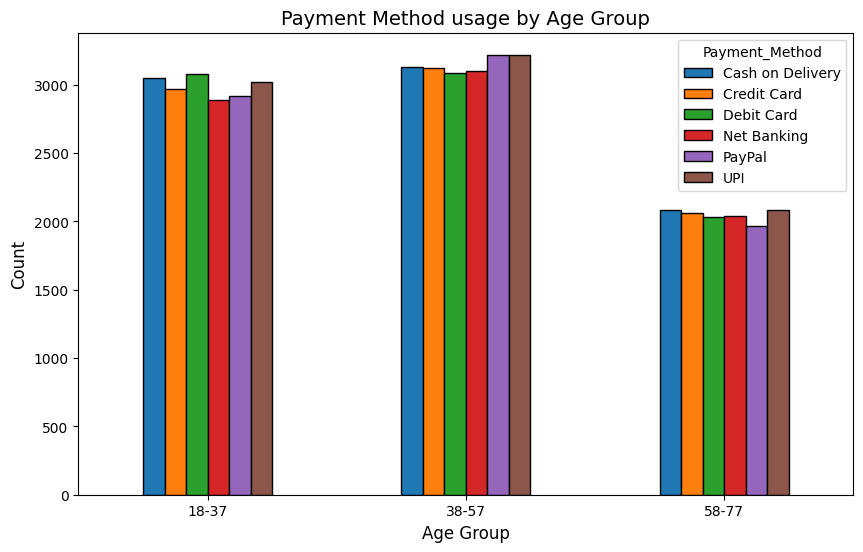

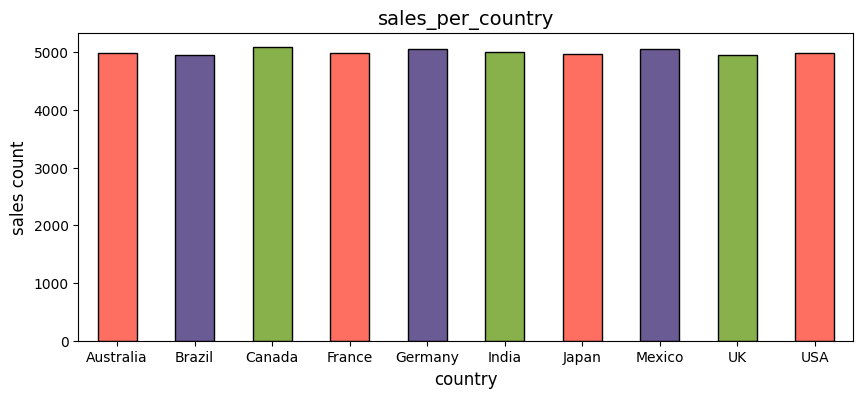

Country
Australia    4985
Brazil       4948
Canada       5082
France       4993
Germany      5047
India        4996
Japan        4960
Mexico       5059
UK           4951
USA          4979
Name: count, dtype: int64


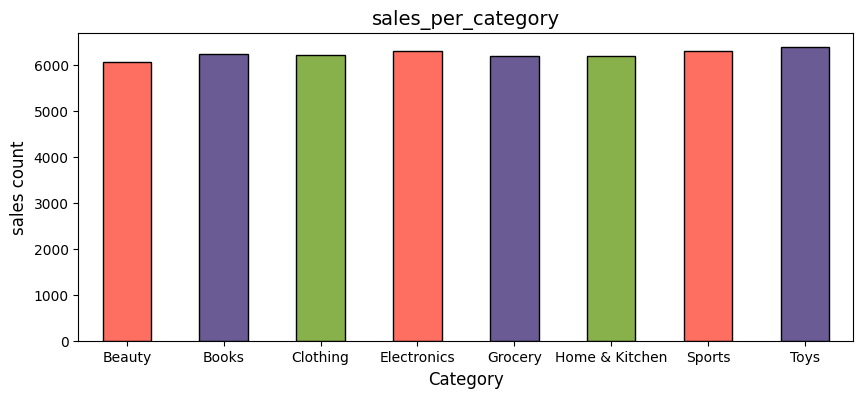

Product_Category
Beauty            6075
Books             6253
Clothing          6224
Electronics       6320
Grocery           6215
Home & Kitchen    6209
Sports            6312
Toys              6392
Name: count, dtype: int64
Product_Category  Beauty  Books  Clothing  Electronics  Grocery  \
Age_Group                                                         
18-25                816    822       786          799      793   
26-57               3622   3806      3890         3809     3723   
58-77               1511   1499      1444         1580     1578   

Product_Category  Home & Kitchen  Sports  Toys  
Age_Group                                       
18-25                        815     837   833  
26-57                       3784    3807  3849  
58-77                       1502    1557  1596  


C:\Users\User\AppData\Local\Temp\ipykernel_11404\3264426025.py:97: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  payment_age = df.groupby(["Age_Group", "Product_Category"]).size().unstack(fill_value=0)


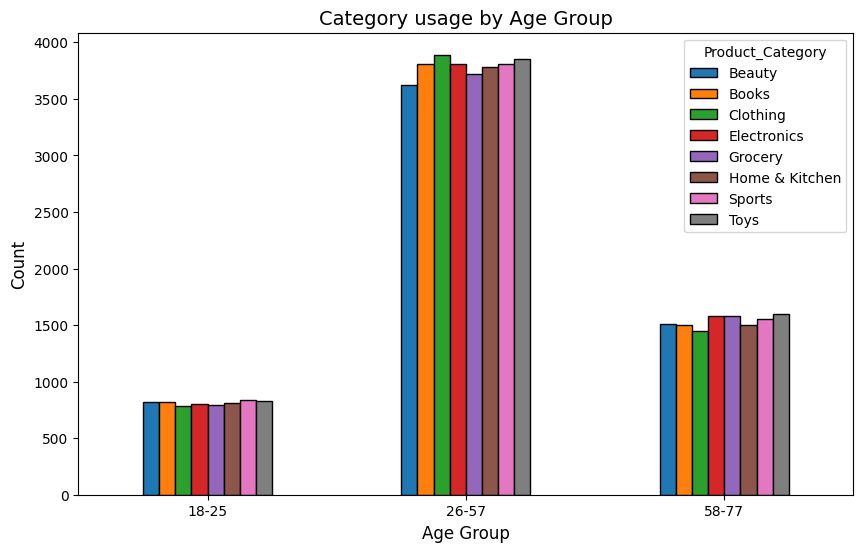

In [12]:
### EDA
### dar har sal che meghdar kharid dashtim???

colors = ["#FF6F61", "#6B5B95", "#88B04B"]
### Tabe rasme bar plot
def count_bar_plot(G,H,val_count,bar_plot_title,bar_plot_ylabel,bar_plot_xlabel):
    sales_per_year = df[val_count].value_counts().sort_index()
     
    sales_per_year.plot(
        kind="bar",
        color=colors,
        figsize=(G,H),
        edgecolor="black"
    )

    plt.title(bar_plot_title , fontsize=14)
    plt.xlabel(bar_plot_xlabel, fontsize=12)
    plt.ylabel(bar_plot_ylabel, fontsize=12)
    plt.xticks(rotation=0)   
    plt.show()
    print(sales_per_year)
count_bar_plot(val_count="Year",bar_plot_title="sales_per_year",bar_plot_ylabel="sales count",bar_plot_xlabel="year",G=6,H=4)
### foroosh dar har mah

count_bar_plot(val_count="Month",bar_plot_title="sales_per_month",bar_plot_xlabel="Month",bar_plot_ylabel="sales count",G=6,H=4)

### in foroosh hame mah ha dar 3 sale bood man foroosh joda shode har mah dar har sal ro ham mikham
def somthing_per_somthing_else(y,z,title,xlabel,ylabel):
    x = df.groupby([y,z]).size().unstack(fill_value=0).sort_index()

    

    x.T.plot(kind="bar", figsize=(10,5), edgecolor="black")
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=0)
    plt.show()
    print(x)
somthing_per_somthing_else( y = "Year" , z = "Month",title ="sales per month by year" ,  xlabel= "Month",ylabel = "sales count")
### user age count.
user_age  =df["Age"].value_counts().sort_index()
user_age.plot(
    kind="bar",
    color = colors,
    figsize=(30,4),
    edgecolor = "black"
)
plt.title("users Age",fontsize = 14)
plt.xlabel("Age",fontsize = 12)
plt.ylabel("count",fontsize = 12)
plt.xticks(rotation = 0)
plt.show()
print(user_age)
### user age per Purchase_Amount
def scatter_plot(dataFC1,dataFC2,scatter_xlabel,scatter_ylabel,scatter_title,C,V):
    
    plt.figure(figsize=(C,V))
    plt.scatter(
        df[dataFC1], 
        df[dataFC2], 
        alpha=0.3,          
        color="teal",
        edgecolors="w",
        linewidths=0.2
    )
    plt.title(scatter_title, fontsize=14)
    plt.xlabel(scatter_xlabel, fontsize=12)
    plt.ylabel(scatter_ylabel, fontsize=12)
    plt.show()
scatter_plot(dataFC1="Age",dataFC2="Purchase_Amount",scatter_title="Purchase Amount vs Age",scatter_xlabel="Age",scatter_ylabel="Purchase Amount",C=8,V=5)
### payment method
count_bar_plot(val_count="Payment_Method",bar_plot_xlabel="payment_method",bar_plot_ylabel= "Count",bar_plot_title="payment_method_count",G=10,H=4)
### payment method per Age
df["Age_Group"] = pd.cut(df["Age"], bins=[18, 37, 57, 77], labels=["18-37", "38-57", "58-77"])

payment_age = df.groupby(["Age_Group", "Payment_Method"]).size().unstack(fill_value=0)

print(payment_age)  

payment_age.plot(kind="bar", figsize=(10,6), edgecolor="black")
plt.title("Payment Method usage by Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.show()


### contry count
count_bar_plot(val_count="Country",bar_plot_title="sales_per_country",bar_plot_ylabel="sales count",bar_plot_xlabel="country",G=10,H=4)

### Product_Category
count_bar_plot(val_count="Product_Category",bar_plot_title="sales_per_category",bar_plot_ylabel="sales count",bar_plot_xlabel="Category",G=10,H=4)
### Product_Category per AGE
df["Age_Group"] = pd.cut(df["Age"], bins=[18, 25, 57, 77], labels=["18-25", "26-57", "58-77"])

payment_age = df.groupby(["Age_Group", "Product_Category"]).size().unstack(fill_value=0)

print(payment_age)  

payment_age.plot(kind="bar", figsize=(10,6), edgecolor="black")
plt.title("Category usage by Age Group", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.show()
### EDA END.


# 📊 Exploratory Data Analysis (EDA)

## Sales per Year
- 2023: ~20k sales  
- 2024: ~25k sales (peak year)  
- 2025: ~5k sales (incomplete data or drop in sales)

---

## Sales per Month
- Monthly sales are fairly **stable** across all 12 months (~4k–4.2k each).  
- No strong seasonality is visible.

---

## Sales per Month by Year
- Both 2023 and 2024 have consistent monthly sales.  
- 2025 shows **low counts** (likely partial year or dataset cutoff).

---

## Users’ Age Distribution
- Ages span **18–70 years**.  
- Distribution is almost **uniform**, no sharp peaks.

---

## Purchase Amount vs Age
- Purchase amount (5–1000) is **spread evenly** across all ages.  
- No strong correlation between age and purchase amount.

---

## Payment Method Count
- Six methods used almost equally: **COD, Credit, Debit, NetBanking, PayPal, UPI**.  
- No clear dominance of a single payment method.

---

## Payment Method by Age Group
- Across age groups (18–37, 38–57, 58–77), **all methods are equally popular**.  
- Slightly lower usage in the oldest group (58–77).

---

## Sales per Country
- All 10 countries show nearly **equal sales (~5k each)**.  
- Dataset seems **balanced by country**.

---

## Sales per Category
- 8 product categories (Beauty, Books, Clothing, Electronics, Grocery, Home & Kitchen, Sports, Toys).  
- Each has ~6.2k sales → **perfectly balanced classes**.

---

## Product Category by Age Group
- **26–57 age group dominates** purchases across all categories.  
- 18–25 and 58–77 buy less, but still **spread evenly across categories**.  
- No single category is tied to a specific age group.

---

<div dir="rtl" align="right">

# 📊 تحلیل اکتشافی داده‌ها (EDA)

## فروش به تفکیک سال
- سال ۲۰۲۳: حدود ۲۰ هزار خرید  
- سال ۲۰۲۴: حدود ۲۵ هزار خرید (بیشترین)  
- سال ۲۰۲۵: حدود ۵ هزار خرید (احتمالاً داده ناقص یا افت فروش)

---

## فروش به تفکیک ماه
- فروش ماهانه تقریباً **ثابت** است (حدود ۴ تا ۴.۲ هزار در هر ماه).  
- الگوی فصلی خاصی دیده نمی‌شود.

---

## فروش ماهانه به تفکیک سال
- سال‌های ۲۰۲۳ و ۲۰۲۴ الگوی مشابه و پایدار دارند.  
- سال ۲۰۲۵ فروش **خیلی کم** دارد (احتمالاً داده ناقص).

---

## توزیع سن کاربران
- بازهٔ سنی ۱۸ تا ۷۰ سال.  
- توزیع تقریباً یکنواخت و بدون قله‌های بزرگ.

---

## مبلغ خرید بر اساس سن
- بازهٔ خرید ۵ تا ۱۰۰۰ در همهٔ سنین پراکنده است.  
- ارتباط قوی بین سن و مبلغ خرید وجود ندارد.

---

## روش‌های پرداخت
- شش روش اصلی استفاده می‌شوند: **پرداخت در محل، کارت اعتباری، کارت دبیت، بانک آنلاین، پی‌پال، UPI**.  
- همه تقریباً به یک اندازه استفاده شده‌اند.

---

## روش پرداخت به تفکیک گروه سنی
- در همه گروه‌های سنی (۱۸–۳۷، ۳۸–۵۷، ۵۸–۷۷) روش‌های پرداخت تقریباً یکسان‌اند.  
- گروه مسن‌تر (۵۸–۷۷) کمی کمتر خرید کرده.

---

## فروش به تفکیک کشور
- ده کشور تقریباً تعداد فروش یکسان دارند (~۵ هزار).  
- داده‌ها به شکل **متعادل بین کشورها** پخش شده.

---

## فروش به تفکیک دستهٔ محصول
- ۸ دسته محصول (زیبایی، کتاب، پوشاک، الکترونیک، خواربار، خانه و آشپزخانه، ورزش، اسباب‌بازی).  
- همه با تعداد تقریباً برابر (~۶.۲ هزار) → **کلاس‌ها کاملاً متعادل**.

---

## دستهٔ محصول به تفکیک گروه سنی
- گروه سنی **۲۶–۵۷ سال بیشترین خرید** را دارد در همه دسته‌ها.  
- گروه‌های ۱۸–۲۵ و ۵۸–۷۷ کمتر خرید می‌کنند ولی الگو بین دسته‌ها یکنواخت است.  
- هیچ دستهٔ خاصی مختص سن خاصی نیست.

</div>


In [ ]:
### preprocessing
### alan darim sotoon ha ro be soorate one hot encoding mikonim 
### ealat asly ine ke model nemitoone dade haro be soorate object dark nemikone
df = pd.get_dummies(df, columns=["Country"],dtype = int)

### hala baiad Payment method ro ham be soorate oneHot encoder daram
df = pd.get_dummies(df,columns = ["Payment_Method"], dtype=int)
### sotoone age_group ba age hampooshani dara az aval ham bara rasme plot sakhteshode
### pas hazfesh mikonim
df.drop("Age_Group",axis =1 ,inplace = True)
### sotoone Product_Category goutooh bandi mikonim

### elat in kar ine khodam bedoonam shomare har gorooh bara chie .
mapping = {
    "Sports": 1,
    "Toys": 2,
    "Beauty": 3,
    "Books": 4,
    "Clothing": 5,
    "Electronics": 6,
    "Grocery": 7,
    "Home & Kitchen": 8,

}


df["Product_Category_Label"] = df["Product_Category"].map(mapping)

print(df[["Product_Category", "Product_Category_Label"]].head())

df.drop("Product_Category",axis=1,inplace=True)


print(df.shape)
print(df.dtypes)

  Product_Category  Product_Category_Label
0         Clothing                       5
1           Beauty                       3
2            Books                       4
3           Sports                       1
4           Beauty                       3
(50000, 22)
Age                                  int64
Purchase_Amount                    float64
Year                                 int32
Month                                int32
Day                                  int32
Country_Australia                    int64
Country_Brazil                       int64
Country_Canada                       int64
Country_France                       int64
Country_Germany                      int64
Country_India                        int64
Country_Japan                        int64
Country_Mexico                       int64
Country_UK                           int64
Country_USA                          int64
Payment_Method_Cash on Delivery      int64
Payment_Method_Credit Card           int64

# ⚙️ Preprocessing Steps

## Encoding Categorical Features
- Applied **One-Hot Encoding** for:
  - `Country` → created binary columns (e.g., `Country_Australia`, `Country_India`, …).
  - `Payment_Method` → created binary columns (e.g., `Payment_Method_Credit Card`, `Payment_Method_UPI`, …).
- Reason: machine learning models cannot interpret categorical/text (`object`) values directly.

## Dropping Unnecessary Columns
- `Age_Group` → initially created for plotting only, removed to avoid overlap with raw `Age`.
- `Product_Category` → replaced by a numerical label column.

## Target Encoding
- Mapped `Product_Category` to numeric labels for supervised learning:
  - Sports → 1  
  - Toys → 2  
  - Beauty → 3  
  - Books → 4  
  - Clothing → 5  
  - Electronics → 6  
  - Grocery → 7  
  - Home & Kitchen → 8  

→ Created new column: `Product_Category_Label` (the target variable).

---

## Final Dataset
- Shape: **50,000 rows × 22 columns**
- Feature types:
  - **Numeric (int64/int32/float64):** Age, Purchase_Amount, Year, Month, Day, one-hot encoded columns.
  - **Target:** `Product_Category_Label` (int64)

---

<div dir="rtl" align="right">

# ⚙️ مراحل پیش‌پردازش

## کدگذاری ویژگی‌های متنی
- **وان‌هات (One-Hot Encoding)** برای ستون‌ها:
  - `Country` → ستون‌های باینری مثل `Country_Australia`، `Country_India` و …  
  - `Payment_Method` → ستون‌های باینری مثل `Payment_Method_Credit Card`، `Payment_Method_UPI` و …  
- دلیل: مدل‌های یادگیری ماشین نمی‌توانند داده‌های متنی (`object`) را مستقیماً پردازش کنند.

## حذف ستون‌های اضافی
- `Age_Group` → فقط برای ترسیم نمودار ساخته شده بود، به دلیل هم‌پوشانی با `Age` حذف شد.  
- `Product_Category` → چون با ستون عددی جدید جایگزین شد، حذف شد.

## برچسب‌گذاری هدف
- ستون `Product_Category` به عدد تبدیل شد تا برای یادگیری نظارت‌شده استفاده شود:  
  - Sports → ۱  
  - Toys → ۲  
  - Beauty → ۳  
  - Books → ۴  
  - Clothing → ۵  
  - Electronics → ۶  
  - Grocery → ۷  
  - Home & Kitchen → ۸  

→ ستون جدید ساخته شد: `Product_Category_Label` (ستون هدف).

---

## دیتاست نهایی
- اندازه: **۵۰,۰۰۰ رکورد × ۲۲ ستون**
- نوع داده‌ها:
  - **عددی (int64/int32/float64):** Age، Purchase_Amount، Year، Month، Day و ستون‌های وان‌هات‌شده.  
  - **هدف:** `Product_Category_Label` (int64)

</div>


In [14]:
### model traning...
X = df.drop(["Product_Category_Label"], axis=1)
y = df["Product_Category_Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def Logistic_Regression(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1
    )
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    return logreg, y_pred
model, y_pred = Logistic_Regression(X_train, X_test, y_train, y_test)

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.125

Classification Report:
               precision    recall  f1-score   support

           1       0.13      0.16      0.14      1262
           2       0.13      0.25      0.17      1278
           3       0.08      0.00      0.01      1215
           4       0.11      0.12      0.12      1251
           5       0.12      0.10      0.11      1245
           6       0.13      0.30      0.18      1264
           7       0.14      0.05      0.08      1243
           8       0.00      0.00      0.00      1242

    accuracy                           0.12     10000
   macro avg       0.10      0.12      0.10     10000
weighted avg       0.10      0.12      0.10     10000



# 🤖 Model Training – Logistic Regression

## Setup
- **Features (X):** all numeric + one-hot encoded columns  
- **Target (y):** `Product_Category_Label`  
- Data split: **80% train, 20% test**, stratified to keep class balance.

## Model
- Algorithm: **Multinomial Logistic Regression**
- Solver: `lbfgs`
- Iterations: `max_iter = 1000`
- Multiclass handling: `multi_class = multinomial`

## Results
- **Accuracy:** ~0.125 (≈ random guessing across 8 classes)  
- Precision/Recall/F1 per class are low, some classes nearly **unrecognized** by the model.  
- Indicates that **linear decision boundaries** are not sufficient for this dataset.

---

<div dir="rtl" align="right">

# 🤖 آموزش مدل – رگرسیون لجستیک

## تنظیمات
- **ویژگی‌ها (X):** تمام ستون‌های عددی + وان‌هات‌ها  
- **هدف (y):** ستون `Product_Category_Label`  
- تقسیم داده: **۸۰٪ آموزش، ۲۰٪ تست** با stratify برای حفظ تعادل کلاس‌ها

## مدل
- الگوریتم: **رگرسیون لجستیک چندکلاسه (Multinomial)**  
- حل‌کننده: `lbfgs`  
- تکرار: `max_iter = 1000`  
- مدیریت چندکلاسه: `multi_class = multinomial`

## نتایج
- **دقت:** حدود ۰.۱۲۵ (تقریباً معادل حدس تصادفی بین ۸ کلاس)  
- مقادیر Precision/Recall/F1 برای اکثر کلاس‌ها پایین است و برخی دسته‌ها **اصلاً شناسایی نشدند**.  
- نتیجه: مرزهای خطی لجستیک برای این داده **کافی نیستند** و باید سراغ مدل‌های قوی‌تر برویم.

</div>


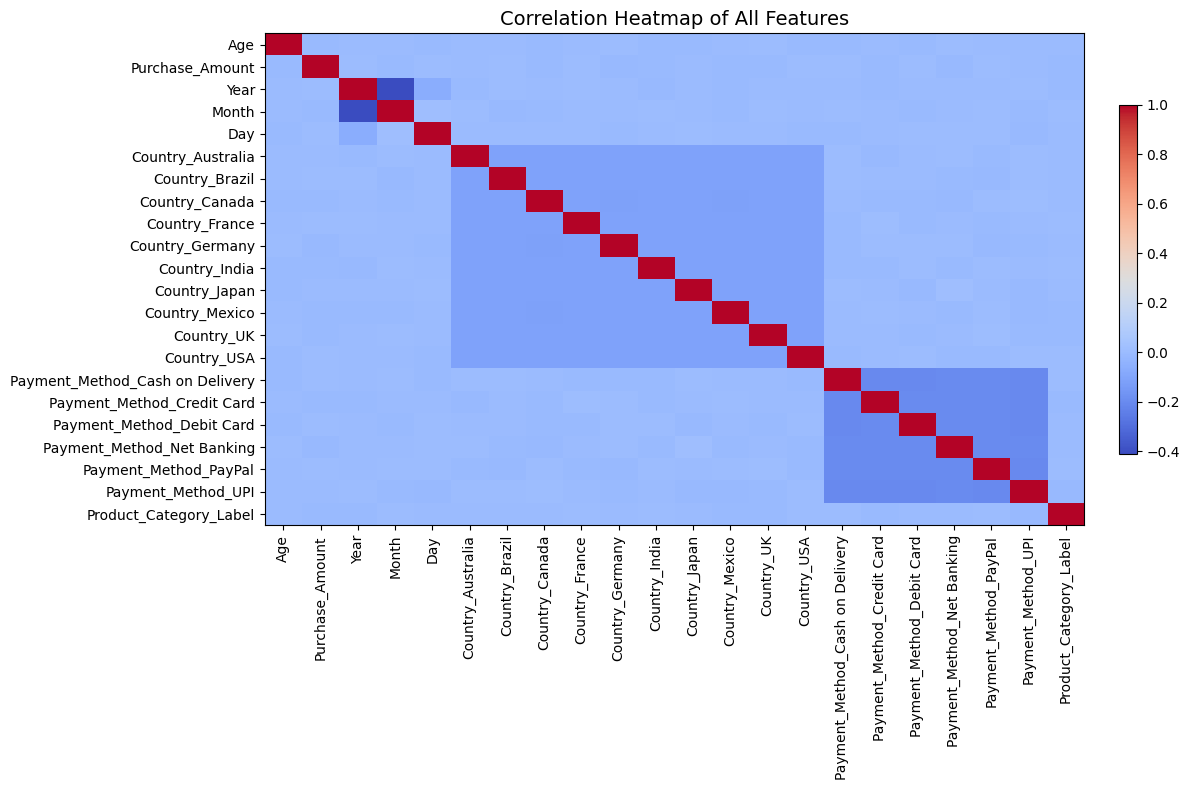

In [ ]:

corr = df.corr(numeric_only=True)

plt.figure(figsize=(12,8))
im = plt.imshow(corr, cmap="coolwarm", aspect="auto")

# colorbar
plt.colorbar(im, fraction=0.02, pad=0.04)


plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Heatmap of All Features", fontsize=14)
plt.tight_layout()
plt.show()


# 📉 Correlation Analysis & Project Conclusion

## Heatmap Insights
- Correlation heatmap shows **weak or no correlation** between features and target (`Product_Category_Label`).  
- This explains the poor performance of Logistic Regression (~0.12 accuracy).  
- Even advanced models (Random Forest, XGBoost) may struggle without stronger features.  

## Next Steps (Future Work)
- Apply **Feature Engineering**:
  - Create interaction features (e.g., `Country × Payment_Method`, `Age_Group × Purchase_Band`).  
  - Extract temporal features: `DayOfWeek`, `Quarter`, `IsWeekend`.  
  - Explore embedding-based representations for categorical variables.  
- Consider **Recommender System approaches** (Collaborative Filtering, Matrix Factorization) if user-product interaction data becomes available.  

## Current Status
- Project is **paused** at this stage.  
- Dataset in current form does not provide enough predictive signal for reliable classification.  

## Key Takeaway
👉 This project highlights a fundamental principle in Machine Learning:  
**“Better features often matter more than better models.”**  
Without meaningful features, even the most advanced algorithms cannot achieve strong performance.

---

<div dir="rtl" align="right">

# 📉 تحلیل همبستگی و جمع‌بندی پروژه

## نتایج Heatmap
- همبستگی بین ویژگی‌ها و ستون هدف (`Product_Category_Label`) بسیار ضعیف یا نزدیک به صفر است.  
- این موضوع دلیل عملکرد ضعیف Logistic Regression (~۰.۱۲ دقت) را توضیح می‌دهد.  
- حتی مدل‌های غیرخطی (مثل Random Forest یا XGBoost) هم بدون فیچرهای قوی احتمالاً بهبود چشمگیری ندارند.  

## گام‌های بعدی (کارهای آتی)
- انجام **Feature Engineering**:
  - ساخت ویژگی‌های تعاملی مثل `Country × Payment_Method` یا `Age_Group × Purchase_Band`.  
  - استخراج ویژگی‌های زمانی مثل `DayOfWeek`، `Quarter`، `IsWeekend`.  
  - بررسی نمایش embedding برای داده‌های متنی/دسته‌ای.  
- در صورت دسترسی به داده‌های تعامل کاربر–محصول، بررسی **روش‌های سیستم توصیه‌گر** (Collaborative Filtering, Matrix Factorization).  

## وضعیت فعلی
- پروژه در این مرحله **متوقف** می‌شود.  
- داده‌ها در حالت فعلی سیگنال کافی برای پیش‌بینی دقیق دستهٔ محصول ندارند.  

## نکته کلیدی
👉 این پروژه یک اصل مهم در یادگیری ماشین را یادآوری می‌کند:  
**«اهمیت فیچرها از مدل هم بیشتر است.»**  
اگر ویژگی‌ها معنادار و تمایزبخش نباشند، حتی پیشرفته‌ترین مدل‌ها هم نتیجهٔ مطلوب نخواهند داد.  

</div>
